In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Dataset.csv")

# View basic info
print(df.head())#returns the first 5 rows
print(df.describe())




   distance_cm  safe_distance_cm  distance_error_cm  target_velocity_cmps  \
0           98                15                 83                    30   
1           97                24                 73                    30   
2           94                36                 58                    30   
3           94                43                 51                    30   
4           94                45                 49                    30   

   actual_velocity_cmps  velocity_error_cmps  pid_output  pwm_output  
0                     0                   30          83         197  
1                     9                   21          73         110  
2                    21                    9          58          75  
3                    28                    2          51          54  
4                    30                    0          49           0  
       distance_cm  safe_distance_cm  distance_error_cm  target_velocity_cmps  \
count   680.000000        680.

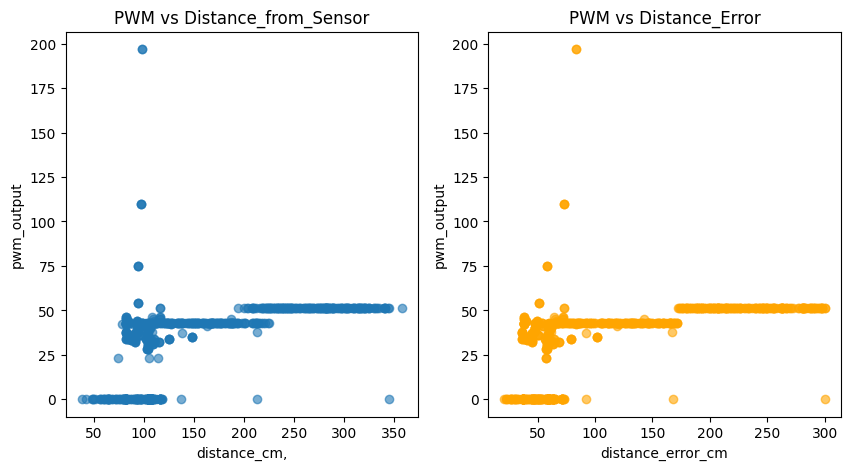

In [3]:
plt.figure(figsize=(10,5))#10x5 inches
plt.subplot(1,2,1)
plt.scatter(df['distance_cm'], df['pwm_output'], alpha=0.6)
plt.xlabel('distance_cm,')
plt.ylabel('pwm_output')
plt.title('PWM vs Distance_from_Sensor')

plt.subplot(1,2,2)
plt.scatter(df['distance_error_cm'], df['pwm_output'], alpha=0.6, color='orange')
plt.xlabel('distance_error_cm')
plt.ylabel('pwm_output')
plt.title('PWM vs Distance_Error')
plt.show()


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[['velocity_error_cmps', 'distance_error_cm','pid_output']]
y = df['pwm_output']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#if our dataset has 100 samples
#After splitting (test_size=0.2 → 20 test samples):
#X_train,y_train= 80 samples used to fit the model
#X_test,y_test= 20 samples used later to evaluate performance

#When you set random_state=42, it ensures that:
#The random shuffling happens the same way every time
#You always get the same train-test split
#Your results are reproducible

# Normalize for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ==== PRINT SCALER VALUES (for Raspberry Pi normalization) ====
print("Feature Means:", scaler.mean_)
print("Feature STDs:", scaler.scale_)


Feature Means: [  1.02941176 117.44669118  27.03125   ]
Feature STDs: [ 2.60144523 80.79292765 32.24425589]


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(3,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)  # Output: PWM
])
model.summary();
model.compile(optimizer='adam', loss='mse', metrics=['mae'])#adam=adaptive gradient descent
history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=16, validation_split=0.1, verbose=1)


D:\Python\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 605 (2.36 KB)

 Trainable params: 605 (2.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 1740.7261 - mae: 35.1758 - val_loss: 1685.0563 - val_mae: 37.1324
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1703.9814 - mae: 34.8836 - val_loss: 1621.8219 - val_mae: 36.5100
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1609.9142 - mae: 34.0849 - val_loss: 1450.6146 - val_mae: 34.7413
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1361.3602 - mae: 31.7565 - val_loss: 1020.8130 - val_mae: 29.6333
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 858.7678 - mae: 25.5778 - val_loss: 365.9631 - val_mae: 17.3745
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 388.7943 - mae: 16.2258 - val_loss: 224.1510 - val_mae: 11.5630
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 324.1738 - mae: 14.5766 - val_loss: 198.3402 - val_mae: 11.2470
Epoch 8/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 288.4382 - mae: 14.0946 - val_loss: 185.9377 - val_mae: 11.1485


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² Score: 0.9830
MSE: 6.6736


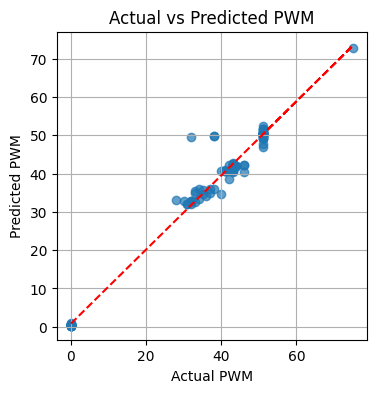

In [8]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")

# Compare actual vs predicted
plt.figure(figsize=(4,4))
plt.scatter(y_test, y_pred, alpha=0.7)

a, b = np.polyfit(y_test, y_pred, 1)
y_fit = a * y_test + b
plt.plot(y_test, y_fit, color='red', linestyle='--', label='Best-Fit Line')

plt.xlabel("Actual PWM")
plt.ylabel("Predicted PWM")
plt.title("Actual vs Predicted PWM")
plt.grid(True)
plt.show()


In [7]:
model.save("model_trained_pid.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open("pid_mimic_model_quant.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("✅ Quantized model saved as pid_mimic_model_quant.tflite")


INFO:tensorflow:Assets written to: C:\Users\ARIJIT\AppData\Local\Temp\tmpcyp8xfcp\assets


INFO:tensorflow:Assets written to: C:\Users\ARIJIT\AppData\Local\Temp\tmpcyp8xfcp\assets


Saved artifact at 'C:\Users\ARIJIT\AppData\Local\Temp\tmpcyp8xfcp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2795528462288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795528463632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795528463248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795528464016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795528463824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795528464400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795528462864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795528464976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795528463440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795528465168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795528463056: